In [1]:
import numpy as np
from scipy import signal
import matplotlib
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import *
from os.path import *
from os import listdir
import h5py
import json
import copy
import sys
sys.path.append('../Databases/')
from database import *

In [2]:
ROOT_FOLDER = realpath('.')
Dver = 'v10'
SIM_FOLDER = 'save/'+Dver+'/Pois_SSCTx2/'
NEURON_PREFIX = 'neuron'
NEST_PREFIX = 'nest'

databases_file = join(ROOT_FOLDER, "ElecDB2.db")
# file_ = join(ROOT_FOLDER, 'ptneu_brain_v9_test_Nest.h5')
file_ = join(ROOT_FOLDER, 'whole_brain_model_Nest.h5')

In [3]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return np.array([float(int(value[i:i + lv // 3], 16)) for i in range(0, lv, lv // 3)])

In [4]:
def makeLegendFig(figname, labels, colors, numColumns = 1):
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    handles = [f("s", colors[i]) for i in range(3)]
    labelsMAXLEN = np.array([len(str1) for str1 in labels])
    labelsSPLIT = np.split(labels, np.array(range(0,1+len(labels),int(np.ceil(float(len(labels))/float(numColumns)))))[1:] )
    colorsSPLIT = np.split(colors, np.array(range(0,1+len(labels),int(np.ceil(float(len(labels))/float(numColumns)))))[1:] )
    colLength = (0.5+0.13*np.max(labelsMAXLEN))
    fig = plt.figure(figsize=( colLength*float(numColumns), 0.25*float(len(colors))/float(numColumns)))
    for iC in range(numColumns):
        patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labelsSPLIT[iC], colorsSPLIT[iC])]
        fig.legend(patches, labelsSPLIT[iC], loc=(0.0+float(iC)*(1.0/float(numColumns)),0.0), frameon=False)
    plt.savefig(figname)


In [5]:
included_regions = ["Primary somatosensory area, lower limb", 'Ventral posteromedial nucleus of the thalamus'] # Specific regions of the database targeted
regions_labels = ['SSCtx:HL', 'VPN'] 

db = BrainDB(databases_file)
region_cond = db.getMouseBrainConds(leafs=True)
# full_name contains the region name so we set the with_like flag
region_cond.append(Region.table.condition(column="full_name", 
                                          included=included_regions, with_like=True))
request = db.getRegions(region_cond)
id_to_region_dictionary = {}
id_to_region_dictionary_ALLNAME = {}
region_dictionary_to_id = {}
region_dictionary_to_id_ALLNAME = {}
region_dictionary_to_id_ALLNAME_parent = {}
region_dictionary_to_id_parent = {}
allname2name = {}
name2allname = {}
allnameOrder = {}
regKeys = []
region_names = []
regions_ALLNAME_list = []
is_leaf = []
layers = {}

id_to_color     = {}
region_to_color = {}

iterTMP = 0
rows, headers = db.execute(request=request)
for line in rows:
    id_to_region_dictionary[line[0]] = line[1]
    id_to_region_dictionary_ALLNAME[line[0]] = line[2]
    region_dictionary_to_id[line[1]] = line[0]
    region_dictionary_to_id_ALLNAME[line[2]] = line[0]

    region_dictionary_to_id_ALLNAME_parent[line[2]] = line[2].rsplit("|", 1)[1] 
    region_dictionary_to_id_parent[line[1]] = line[2].rsplit("|", 2)[1]
    allname2name [line[2]]= line[1]
    name2allname [line[1]] = line[2]
    allnameOrder [line[2]] = iterTMP; iterTMP+=1
    regKeys.append(line[0])
    region_names.append(line[1])
    regions_ALLNAME_list.append(line[2])
    is_leaf.append(line[5])
    id_to_color[line[0]] = line[3]
    region_to_color[line[1]] = line[3]

    if line[2].find("Isocortex")>=0:
        if line[2].find("ayer 1")>=0:   layers[line[0]]=1
        elif line[2].find("ayer 2")>=0: layers[line[0]]=2
        elif line[2].find("ayer 3")>=0: layers[line[0]]=3
        elif line[2].find("ayer 4")>=0: layers[line[0]]=4
        elif line[2].find("ayer 5")>=0: layers[line[0]]=5
        elif line[2].find("ayer 6")>=0: layers[line[0]]=6
        else:                           layers[line[0]]=0
    else:
        layers[line[0]]=0

is_leaf = np.array(is_leaf)
filter_ = np.where(is_leaf==1)
region_names = np.array(region_names)[filter_]
regions_ALLNAME_list = np.array(regions_ALLNAME_list)[filter_]
regions_ids = np.array(regKeys)[filter_]

In [6]:
print("Loading h5 file")
h5file = h5py.File(file_, "r")
Larea   = h5file['neurons']["regions"][:]
# Larea   = h5file['neurons']["Larea"][:]
etype   = h5file['neurons']["eTypes"][:]
ETTN    = h5file['neurons']["eTypesToName"][:]
mtype   = h5file['neurons']["neuronTypes"][:]
CTTN    = h5file['neurons']["neuronTypesToName"][:]
xs      = h5file['neurons']["x"][:]
ys      = h5file['neurons']["y"][:]
zs      = h5file['neurons']["z"][:]
Umtype = np.unique(mtype)
Uetype = np.unique(etype)

LTN = ["ALL", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5", "Layer 6"]
print("h5 file loaded")

Loading h5 file
h5 file loaded


In [7]:
json_cont = json.loads(open(join(SIM_FOLDER, "conversion.json"), "r").read())
json_convert = {}
for k, v in json_cont.items():
    json_convert[str(v)] = int(k)
del json_cont

In [8]:
SIM_OUTPUTS = {join(SIM_FOLDER, NEURON_PREFIX+'_output'):False, join(SIM_FOLDER, NEST_PREFIX+'_output'):True}

time_from = 20.00
time_to = 2080.00

for sim, convert in SIM_OUTPUTS.items():
    spikes = {"senders":[], "times":[], "regions":[], "layer":[], "mtype":[], "etype":[]}
    multimeters = {"senders":[], "times":[], "regions":[], "layer":[], "mtype":[], "etype":[], "potentials":[]}
    for f in listdir(sim):
        file_ = join(sim, f)
        if isfile(file_):
            print(f)
            with open(file_, 'r') as f:
                for line in f:
                    splitLine = line.split()
                    if convert:
                        gid = json_convert[splitLine[0]]
                    else:
                        gid = int(splitLine[0])
                    larea = Larea[gid]
                    if float(splitLine[1]) >= time_from and float(splitLine[1]) <= float(time_to) and larea in regions_ids:
                        if "spike_detector-" in file_:
                            spikes["senders"].append(gid)
                            spikes["times"].append(float(splitLine[1]))
                            spikes["regions"].append(larea)
                            spikes["layer"].append(layers[larea])
                            spikes["mtype"].append(mtype[gid])
                            spikes["etype"].append(etype[gid]) 
                        elif "multimeter" in file_:
                            multimeters["senders"].append(gid)
                            multimeters["times"].append(float(splitLine[1]))
                            multimeters["potentials"].append(float(splitLine[2]))
                            multimeters["regions"].append(larea)
                            multimeters["layer"].append(layers[larea])
                            multimeters["mtype"].append(mtype[gid])
                            multimeters["etype"].append(etype[gid])
                    elif float(splitLine[1]) > float(time_to):
                        break;
    spikes['senders'] = np.array(spikes['senders'])
    spikes['times'] = np.array(spikes['times'])
    spikes['regions'] = np.array(spikes['regions'])
    spikes['layer'] = np.array(spikes['layer'])
    spikes['mtype'] = np.array(spikes['mtype'])
    spikes['etype'] = np.array(spikes['etype'])
    
    multimeters['senders'] = np.array(multimeters['senders'])
    multimeters['times'] = np.array(multimeters['times'])
    multimeters['potentials'] = np.array(multimeters['potentials'])
    multimeters['regions'] = np.array(multimeters['regions'])
    multimeters['layer'] = np.array(multimeters['layer'])
    multimeters['mtype'] = np.array(multimeters['mtype'])
    multimeters['etype'] = np.array(multimeters['etype'])
    if len(spikes['senders']) <=0:
        print("No spikes for the interval selected.")
    SIM_OUTPUTS[sim]= [copy.deepcopy(spikes), copy.deepcopy(multimeters)]
    del spikes, multimeters

spike_detector-0.gdf
multimeter-4983-0.dat
spike_detector-4982-0.gdf


In [9]:
ids_ctx = []
ids_thal = []
for id_reg in regions_ids:
    if included_regions[0] in id_to_region_dictionary_ALLNAME[id_reg]:
        ids_ctx.append(id_reg)
    elif included_regions[1] in id_to_region_dictionary_ALLNAME[id_reg]:
        ids_thal.append(id_reg)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in divide


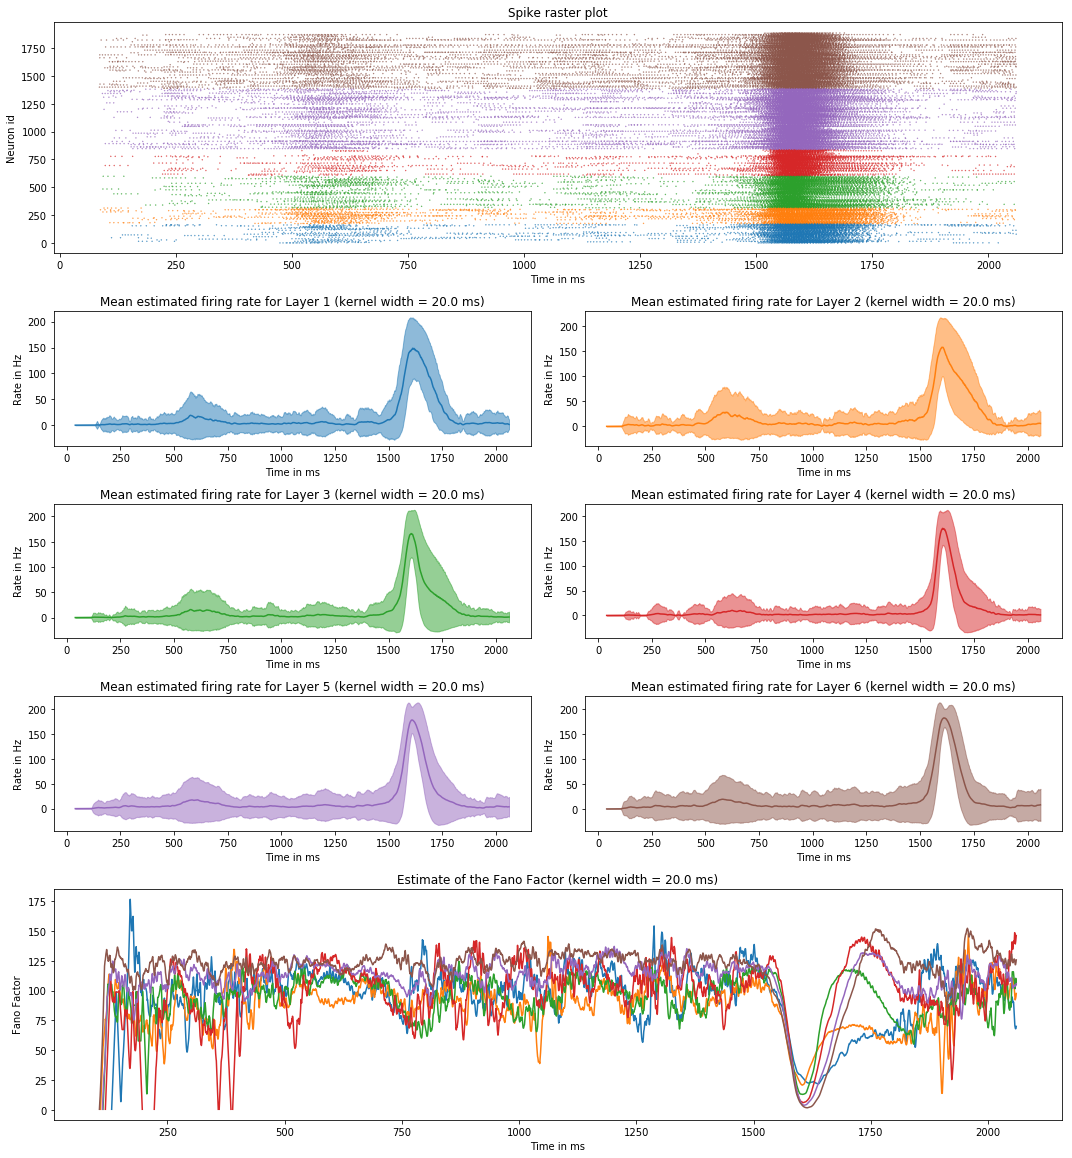

<Figure size 101.52x108 with 0 Axes>

In [10]:
# Spikes plots
nest_res = SIM_OUTPUTS[join(SIM_FOLDER, NEST_PREFIX+'_output')][0]
nrn_res = SIM_OUTPUTS[join(SIM_FOLDER, NEURON_PREFIX+'_output')][0]

dt = 0.1
w_single = 200 # steps ie 20ms
time_resolution = dt /1000. # in second

ids_roi = ids_ctx
roi_name = "SSCtx-HL"
# roi_name = "Thal-VPM"
# roi_name = "ALL"
sim_res = nest_res
sim_name = "NEST"
# sim_name = "Neuron"
splitter = "layer"
names = LTN

filter_ = np.in1d(sim_res['regions'], ids_roi)
loc_filters = sim_res[splitter][filter_]
loc_gids = sim_res["senders"][filter_]
id_times = np.int64(np.round((sim_res['times'][filter_]-time_from)/dt))

#id_times[loc_filters!=1] = 0

uniq_filter = np.unique(loc_filters)
num_filter = len(uniq_filter)
convert = np.zeros(np.max(uniq_filter)+1, int)
inv_convert = np.zeros(num_filter, int)
for i in range(num_filter):
    convert[uniq_filter[i]] = i
    inv_convert[i] = uniq_filter[i]

filter_colors = np.zeros((num_filter+1, 3), np.float32)
for i in range(num_filter):
    if i<10:
        filter_colors[i+1] = hex_to_rgb(plt.rcParams['axes.prop_cycle'].by_key()['color'][i])/255.
    else:
        np.random.seed(i+i*10)
        filter_colors[i+1] = np.random.rand(3)
        if np.sum(filter_colors[i+1])<1.5: filter_colors[i+1] *= 1.5/np.sum(filter_colors[i+1])
        filter_colors[i+1][filter_colors[i+1]>1.0] = 1.0

_, indexes = np.unique(loc_gids, return_index=True)
translate_local2global = loc_gids[indexes]
translate_global2local = -np.ones(np.max(translate_local2global)+1, np.int64)
translate_global2local[translate_local2global] = range(len(translate_local2global))

spikes2D = np.zeros((int(round((time_to-time_from)/dt))+1,len(translate_local2global)), np.int8)
spikes2D[id_times,translate_global2local[loc_gids]] = 1

spikes2D_filter = spikes2D[:,np.argsort(loc_filters[indexes])]
unsorted_colors = filter_colors[convert[loc_filters[indexes]]+1]
gid2color = unsorted_colors[np.argsort(loc_filters[indexes])]


nb_neurons = np.zeros(num_filter)
ufilt = loc_filters[indexes]
for i, uf in enumerate(uniq_filter):
    nb_neurons[i] = len(np.where(ufilt==uf)[0])
counts = np.zeros(num_filter+1)
counts[1:] = np.cumsum(nb_neurons)

fig = plt.figure(figsize=(15, 8+8*num_filter//6)) 
# Fig 1.1: Spike raster plot
length_fr = int(math.ceil(num_filter/2.0))*2
ax1 = plt.subplot2grid((6+length_fr,2), (0,0), colspan=2, rowspan=3)
times, newIds = np.where(spikes2D_filter)
ax1.scatter(times*dt, newIds, marker='.', c=gid2color[newIds], s=0.5)
ax1.set_xlabel('Time in ms')
ax1.set_ylabel('Neuron id')
ax1.set_title('Spike raster plot')

kernel_single = signal.triang(w_single)*2/w_single # normalized boxcar kernel for single-trial firing rate
R = signal.lfilter(kernel_single, 1, spikes2D_filter, axis=0)/time_resolution

time_interval = np.arange(time_from+w_single*dt, time_to-w_single*dt+dt/10., dt)
ax3 = plt.subplot2grid((6+length_fr,2), (3+length_fr,0), colspan=2, rowspan=3)
for i in range(num_filter):
    ax = plt.subplot2grid((6+length_fr,2), (3+i//2*2,i%2), rowspan=2)
    mean = np.mean(R[:, int(counts[i]):int(counts[i+1])], axis=1)
    fano_factor = np.var(R[:, int(counts[i]):int(counts[i+1])], axis=1)/mean
    std = np.std(R[:, int(counts[i]):int(counts[i+1])], axis=1)
    ax.fill_between(time_interval, (mean-std)[w_single:-w_single], (mean+std)[w_single:-w_single], alpha=0.5, color=filter_colors[i+1])
    ax.plot(time_interval, mean[w_single:-w_single], color=filter_colors[i+1])
    ax3.plot(time_interval, fano_factor[w_single:-w_single], color=filter_colors[i+1])
    ax.set_xlabel('Time in ms')
    ax.set_ylabel('Rate in Hz')
    ax.set_title('Mean estimated firing rate for '+str(names[inv_convert[i]])+' (kernel width = '+ str(w_single*dt)+' ms)')
plt.tight_layout()


ax3.set_xlabel('Time in ms')
ax3.set_ylabel('Fano Factor')
ax3.set_title('Estimate of the Fano Factor (kernel width = '+ str(w_single*dt)+' ms)')
plt.savefig(join(SIM_FOLDER, sim_name, splitter, sim_name+"_"+roi_name+"_"+splitter+"_fr.png"))

str_list = [""]*num_filter
for i in range(num_filter):
    str_list[i] = names[uniq_filter[i]]
makeLegendFig( SIM_FOLDER+"/legend_"+splitter+".png", labels=str_list, colors=filter_colors[1:], numColumns=num_filter//8+1 )

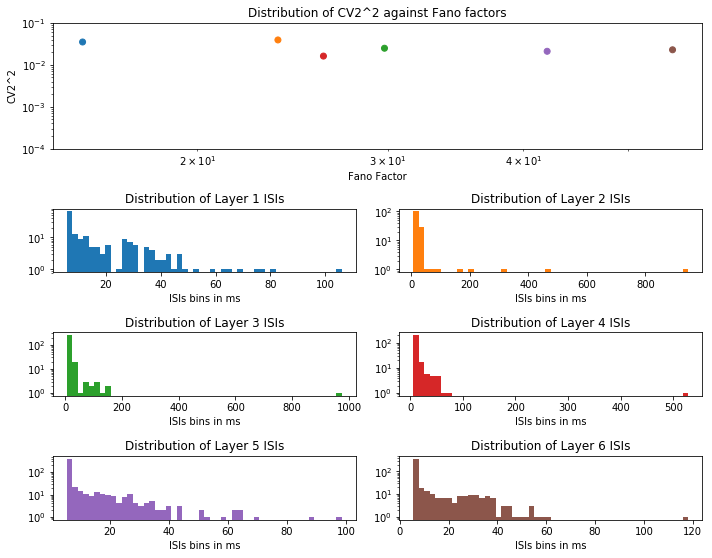

In [11]:
#CV2 + FF against CV2
fig = plt.figure(figsize =(10,4+6*num_filter//6))
fano_factors = []
cv2s = []
isis_dist = []
for i in range(num_filter):
    filter_ = np.where(spikes2D_filter[:, int(counts[i]):int(counts[i+1])])
    ms = []
    spike_counts = np.sum(spikes2D_filter[:, int(counts[i]):int(counts[i+1])], axis=0)
    mean_count = np.mean(spike_counts)
    variance_count = np.var(spike_counts)
    fano_factors.append(variance_count/mean_count)
    isi = []
    for k in range(spikes2D_filter[:, int(counts[i]):int(counts[i+1])].shape[1]):
        isis = np.diff(filter_[0][filter_[1]==k])*0.1
        if len(isis)>0:
            isi.append(np.mean(isis))
            ms = np.concatenate((ms,2*np.absolute(np.diff(isis))/(isis[0:isis.size-1] + isis[1:isis.size])))
    cv2s.append(np.mean(ms))
    isis_dist.append(isi)

ax1 = plt.subplot2grid((6+length_fr,2), (0,0), colspan=2, rowspan=3)
ax1.scatter(fano_factors, np.power(cv2s,2), c=filter_colors[1:])
ax1.set_ylabel('CV2^2')
ax1.set_ylim([1e-4,1e-1])
ax1.set_xlabel('Fano Factor')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Distribution of CV2^2 against Fano factors')

for i in range(num_filter):
    ax2 = plt.subplot2grid((6+length_fr,2), (3+i//2*2,i%2), rowspan=2)
    ax2.hist(isis_dist[i],50, color=filter_colors[i+1])
    ax2.set_xlabel('ISIs bins in ms')
    ax2.set_yscale('log')
    ax2.set_title('Distribution of '+str(names[inv_convert[i]]) + ' ISIs')
plt.tight_layout()
plt.savefig(join(SIM_FOLDER, sim_name, splitter, sim_name+"_"+roi_name+"_"+splitter+"_isi.png"))

In [12]:
print("Loading masks")
mask_axial    = np.zeros((528,528), np.int16)
mask_coronal  = np.zeros((528,528), np.int16)
mask_sagittal = np.zeros((528,528), np.int16)
mask_axial[   264-264:264+264,264-228:264+228] = np.int16(np.load("mask_axial.npy"))
mask_coronal[ 264-160:264+160,264-228:264+228] = np.int16(np.load("mask_coronal.npy"))
mask_sagittal[264-160:264+160,264-264:264+264] = np.int16(np.load("mask_sagittal.npy")).T

Loading masks


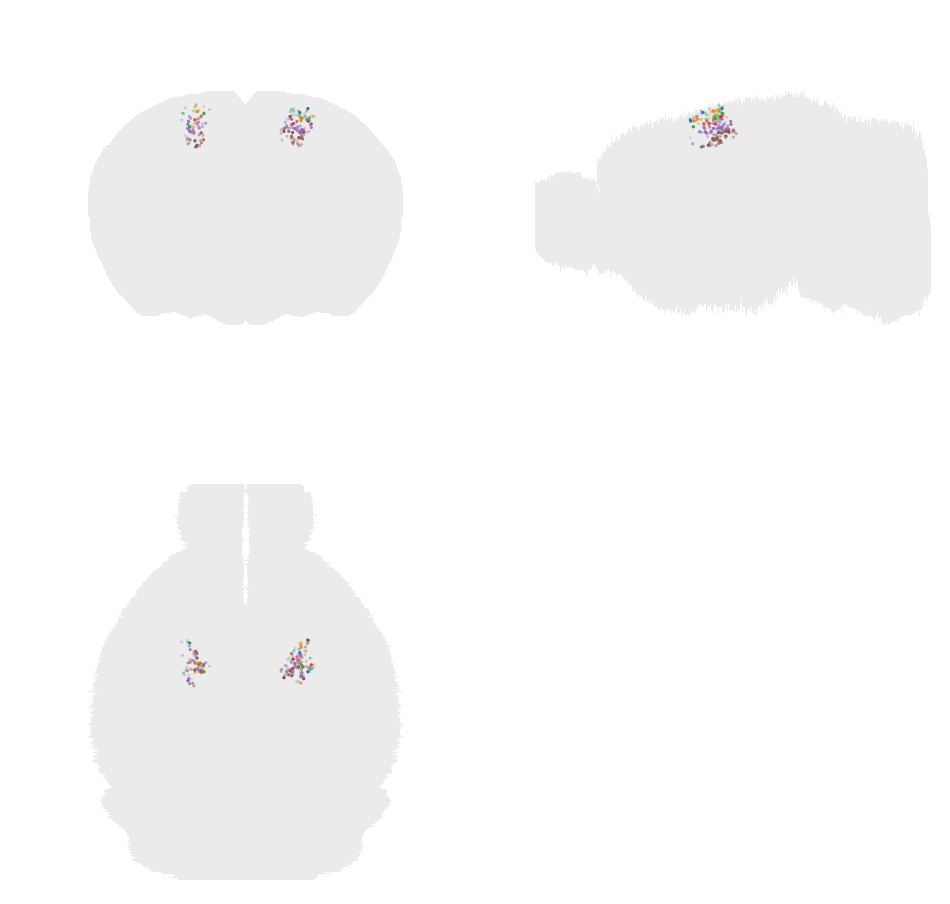

In [17]:
interval = 1 # ms
tau_spike = 2.0 # ms

extent_ = [-528*25.0*0.5,528*25.0*0.5,-528*25.0*0.5,528*25.0*0.5]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( 2,2, figsize=(16,16) )
ax1.imshow( 255-20*mask_coronal, extent=extent_, cmap="gray", vmin=0, vmax=255 )
ax2.imshow( 255-20*mask_sagittal, extent=extent_, cmap="gray", vmin=0, vmax=255  )
ax3.imshow( 255-20*mask_axial, extent=extent_, cmap="gray", vmin=0, vmax=255 )
ax1.axis(extent_); ax1.axis('off')
ax2.axis(extent_); ax2.axis('off')
ax3.axis(extent_); ax3.axis('off')
ax4.axis('off')
sc1 = ax1.scatter( [],[], marker=".", s=20, edgecolor="none")
sc2 = ax2.scatter( [],[], marker=".", s=20, edgecolor="none")
sc3 = ax3.scatter( [],[], marker=".", s=20, edgecolor="none")

def animate(it_):
    global id_times, dt, tau_spike, loc_gids, unsorted_colors, translate_global2local, xs, ys, zs
    spikes_in_dT = np.where( (id_times<float(it_)/dt)*(id_times>float(it_)/dt-2.0*tau_spike/dt) )[0]
    if spikes_in_dT.shape[0]>0:
        sendersTMP = loc_gids[spikes_in_dT]
        alphasTMP  = np.exp( (id_times[spikes_in_dT] - float(it_)/dt) / tau_spike*dt )
        clrsTMP    = np.zeros((spikes_in_dT.shape[0],4))
        clrsTMP[:,:3] = unsorted_colors[translate_global2local[sendersTMP], :]
        clrsTMP[:, 3] = alphasTMP
        sc1.set_offsets(np.array([-zs[ sendersTMP ], ys[ sendersTMP ]]).T)
        sc1.set_color(clrsTMP)
        sc2.set_offsets(np.array([xs[ sendersTMP ], ys[ sendersTMP ]]).T)
        sc2.set_color(clrsTMP)
        sc3.set_offsets(np.array([-zs[ sendersTMP ], -xs[ sendersTMP ]]).T)
        sc3.set_color(clrsTMP)
#         print("Spikes in "+ str(it_), len(sendersTMP)) 
#     plt.title("Axial view of the brain activity - frame "+str(it_)+ " ms")

ani = animation.FuncAnimation(fig, animate, range(int(1500), int(1600), interval), repeat=False)
ani.save(join(SIM_FOLDER, sim_name, splitter, sim_name+"_"+roi_name+"_"+splitter+"_spatial.mp4"),fps=60, codec="h264", extra_args=['-vcodec', 'libx264'])
plt.show()

In [20]:
np.save("../id_times.npy", id_times)
np.save("../loc_gids.npy", loc_gids)
np.save("../unsorted_colors.npy", unsorted_colors)
np.save("../translate_global2local.npy", translate_global2local)
np.save("../xs.npy", xs)
np.save("../ys.npy", ys)
np.save("../zs.npy", zs)

In [ ]:
file_ = join(SIM_FOLDER, "stimulation.gdf")
stim_spikes = []
with open(file_, 'r') as f:
    for line in f:
        splitLine = line.split()
        stim_spikes.append([float(splitLine[0]), int(splitLine[1])])
stim_spikes = np.array(stim_spikes).T

In [ ]:
fig = plt.figure(figsize =(15,6))
plt.scatter(stim_spikes[0], stim_spikes[1], s=0.5)
plt.title("Spikes Stimulus")
plt.tight_layout()
plt.savefig(SIM_FOLDER+ "/"+"poisson_stimuli.png")

In [ ]:
# Membrane potential plots
nest_res = SIM_OUTPUTS[join(SIM_FOLDER, NEST_PREFIX+'_output')][1]
nrn_res = SIM_OUTPUTS[join(SIM_FOLDER, NEURON_PREFIX+'_output')][1]

dt = 0.1
time_resolution = dt /1000. # in second

ids_roi = ids_ctx
roi_name = "SSCtx-HL"
# roi_name = "Thal-VPM"
# roi_name = "ALL"
sim_res = nest_res
sim_name = "NEST"
# sim_name = "Neuron"
splitter = "layer"
names = LTN

filter_ = np.in1d(sim_res['regions'], ids_roi)
loc_filters = sim_res[splitter][filter_]
loc_gids = sim_res["senders"][filter_]
id_times = np.int64(np.round(sim_res['times'][filter_]/dt))
loc_potentials = sim_res['potentials'][filter_]

uniq_filter = np.unique(loc_filters)
num_filter = len(uniq_filter)
convert = np.zeros(np.max(uniq_filter)+1, int)
inv_convert = np.zeros(num_filter, int)
for i in range(num_filter):
    convert[uniq_filter[i]] = i
    inv_convert[i] = uniq_filter[i]

filter_colors = np.zeros((num_filter+1, 3), np.float32)
for i in range(num_filter):
    if i<10:
        filter_colors[i+1] = hex_to_rgb(plt.rcParams['axes.prop_cycle'].by_key()['color'][i])/255.
    else:
        np.random.seed(i+i*10)
        filter_colors[i+1] = np.random.rand(3)
        if np.sum(filter_colors[i+1])<1.5: filter_colors[i+1] *= 1.5/np.sum(filter_colors[i+1])
        filter_colors[i+1][filter_colors[i+1]>1.0] = 1.0

##################################

_, indexes = np.unique(loc_gids, return_index=True)
translate_local2global = loc_gids[indexes]
translate_global2local = -np.ones(np.max(translate_local2global)+1, np.int64)
translate_global2local[translate_local2global] = range(len(translate_local2global))

potentials2D = np.zeros((int(round((time_to-time_from)/dt))+1,len(translate_local2global)), np.float32)
potentials2D[np.int64(np.round(id_times-time_from/dt)),translate_global2local[loc_gids]] = loc_potentials

potentials2D_filter = potentials2D[:,np.argsort(loc_filters[indexes])]
gid2color = filter_colors[convert[loc_filters[indexes]]+1][np.argsort(loc_filters[indexes])]

nb_neurons = np.zeros(num_filter)
ufilt = loc_filters[indexes]
for i, uf in enumerate(uniq_filter):
    nb_neurons[i] = len(np.where(ufilt==uf)[0])
counts = np.zeros(num_filter+1)
counts[1:] = np.cumsum(nb_neurons)


fig = plt.figure(figsize=(15, 8*num_filter//6)) 
length_fr = int(math.ceil(num_filter/2.0))*2
# Fig 3: Membrane heat plot
time_interval = np.arange(time_from, time_to+dt/10., dt)
for i in range(num_filter):
    ax = plt.subplot2grid((length_fr,2), (i//2*2,i%2), rowspan=2)
    mean = np.mean(potentials2D_filter[:, int(counts[i]):int(counts[i+1])], axis=1)
    std = np.std(potentials2D_filter[:, int(counts[i]):int(counts[i+1])], axis=1)
    ax.fill_between(time_interval, mean-std, mean+std, alpha=0.5, color=filter_colors[i+1])
    ax.plot(time_interval, mean, c=filter_colors[i+1])
    ax.set_xlabel('Time in ms')
    ax.set_ylabel('Membrane voltage in mV')
    ax.set_title('Mean membrane voltage other time for '+ names[inv_convert[i]])
plt.tight_layout()
plt.savefig(join(SIM_FOLDER, sim_name, splitter,sim_name+"_"+roi_name+"_"+splitter+"_mean_membrane_potentials.png"))

In [ ]:
figure(figsize=(15, 6))
imshow(potentials2D_filter.T, interpolation="nearest", aspect=4.0, cmap='hot')
cbar = colorbar()
cbar.set_label('Membrane potential in mV', rotation=270)
for il in range(1, num_filter):
    plt.axhline(y=[counts[il]], color='b', linewidth=1)
plt.xlabel('Time in ms')
plt.ylabel('Neuron id')
plt.tight_layout()
plt.savefig(join(SIM_FOLDER, sim_name, splitter,sim_name+"_"+roi_name+"_"+splitter+"_membrane_potentials.png"))